# This notebook contains some experiments on FER2013 dataset

### Dang Thanh Vu - 197796

In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:0')

1.2.0


# Data Preparing

Read data from csv

In [ ]:
data_path = os.path.dirname(os.getcwd()) + "/data/fer/"
csv_file = np.genfromtxt(data_path + "fer2013_publictest_onehot.csv", delimiter =",")

data = csv_file[:, :48*48]
data = data.reshape([-1, 48, 48])
labels = csv_file[:, 48*48:]
labels = np.argmax(labels, axis=1)

Split training and validation set

In [ ]:
n_train = int(data.shape[0]*0.8)

data_train = data[:n_train]
labels_train = labels[:n_train]
data_val = data[n_train:]
labels_val = labels[n_train:]
hf = h5py.File(data_path + 'fer2013_train.h5', 'w')
hf.create_dataset('features', data=data_train)
hf.create_dataset('labels', data=labels_train)
hf.close()

hf = h5py.File(data_path + 'fer2013_val.h5', 'w')
hf.create_dataset('features', data=data_val)
hf.create_dataset('labels', data=labels_val)
hf.close()

In [ ]:
hf = h5py.File(data_path + 'fer2013_test.h5', 'w')
hf.create_dataset('features', data=data)
hf.create_dataset('labels', data=labels)
hf.close()

data saved under ".h5" format, each file has two keys, "features" stands for images, and "labels" stands for class targets.
The values on an image is normalzied between 0 and 1.

In [2]:
class FER(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        input_images = np.array(hf.get('features'), np.uint8)
        target_labels = np.array(hf.get('labels')).astype(np.long)
        self.input_images = input_images
        self.input_labels = target_labels
            
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx] / 255.
        classes = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        images = images[None,:]
        
        return images, classes

Load Training and validation set

In [3]:
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

data_path = os.path.dirname(os.getcwd()) + "/data/fer/"
Train_data = FER(data_path + "fer2013_train.h5")
Val_data = FER(data_path + "fer2013_val.h5")

Train_dataloader = DataLoader(dataset=Train_data, batch_size = 32, shuffle=True)
Val_dataloader = DataLoader(dataset=Val_data, batch_size = 32, shuffle=True)

# show samples

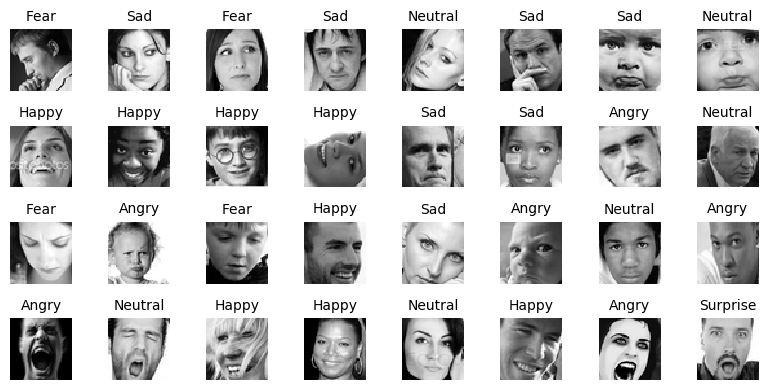

In [4]:
train_images, train_labels = next(iter(Train_dataloader))

def imshow(t, title):
    """Custom function to display the image using matplotlib"""    
    nplots = t.shape[0]
    ncols = 8
    nrows = nplots // ncols
    count = 0
    fig = plt.figure(figsize=(ncols, nrows), dpi=100)
    for i in range(nrows):
        for j in range(ncols):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[count - 1, 0].numpy(), np.float32)

            ax1.imshow(npimg, cmap='gray')
            ax1.set_title(class_names[title[count-1]], fontsize=10)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    
    plt.tight_layout()
    plt.show()
    
imshow(train_images, train_labels)

# Dataset Distribution visualization

Reduce to two-dimensions (sklearn functions) and use scatter plot to visualize the distribution of dataset 

In [5]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def _scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(num_classes):

        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),
                            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txt

### PCA visulization

[0.28975939 0.09847205]


(<Figure size 576x576 with 1 Axes>,
 Text(308.17440157349387, -19.399662083746982, '6'))

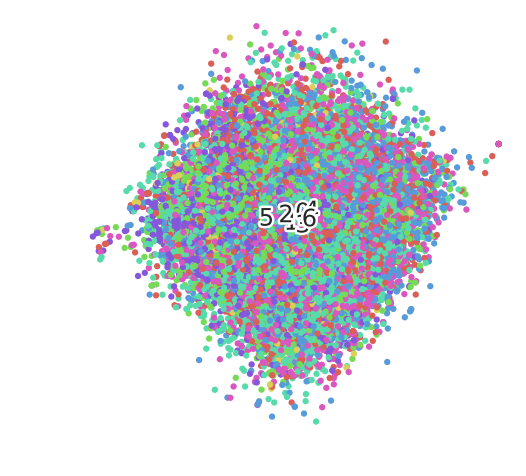

In [6]:
from sklearn.decomposition import PCA

data = Train_data.input_images
labels = Train_data.input_labels

feature_maps = data.reshape([-1, 48*48])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_maps)
print(pca.explained_variance_ratio_)
_scatter(pca_result[:,0:2], labels)

### T-SNE visualization

[0.28975939 0.09847205 0.09474441 0.05445501 0.03042993 0.02582659
 0.02189407 0.01960711 0.01762008 0.01503298 0.01177307 0.01061505
 0.01026903 0.01001065 0.00928374 0.00816055 0.00785426 0.00655583
 0.00552194 0.00535296 0.00526599 0.00501731 0.00487276 0.0046531
 0.00439512 0.0041737  0.00411092 0.00382021 0.00346529 0.0033842
 0.00326869 0.00317997 0.00310655 0.00304346 0.00297524 0.00282358
 0.00274121 0.00255685 0.00249162 0.00246568 0.00230828 0.00220497
 0.00213639 0.00205052 0.00203453 0.00200846 0.00190516 0.00182523
 0.00181575 0.00178645]


(<Figure size 576x576 with 1 Axes>,
 Text(-0.5755195, 7.240858, '6'))

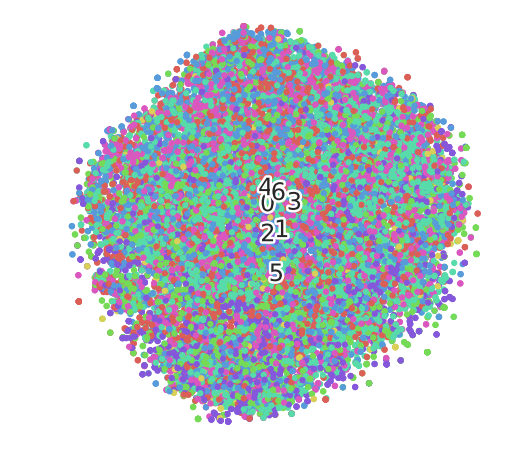

In [7]:
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
pca_result = pca.fit_transform(feature_maps)
print(pca.explained_variance_ratio_)
tsne = TSNE(n_components = 2).fit_transform(pca_result)
_scatter(tsne, labels[:])

# Some functions

Trainning Procedure (loop per epoch and batch): Load dataset -> feed the data into model and call (automatically) forward pass -> calculate loss by a criterion -> call backward to calculate gradients and update weights

In [8]:
def validate(dataloader, model): 
    """Validating a model"""
    model.eval()
    with torch.no_grad():
        c_l_t = np.array([0., 0., 0.])
        for image, label in (dataloader):
            image, label = image.to(device).float(), label.to(device)
            output = model(image)  
            c_l_t += np.array([(torch.argmax(output,dim=1) == label).sum().item(),
                                    criterion(output, label).item(),
                                    label.size(0)])
    
    acc = 100 * c_l_t[0] / c_l_t[2]
    error = c_l_t[1] / c_l_t[2]
            
    return acc, error
        
def training(dataloader, model, check_point="ckpt", EPOCHS = 200):
    """Training a model"""
    log = []
    max_correct = 0
    for epoch in range(1, EPOCHS + 1):
        #training
        print('Epoch[{}/{}]'.format(epoch, EPOCHS))
        _model.train()
        for image, label in tqdm_notebook(dataloader):
            image, label = image.to(device).float(), label.to(device)
            output = model(image)
            loss = criterion(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #validation
        acc_train, loss_train = validate(Train_dataloader, model)
        print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_train, acc_train))
        acc_val, loss_val = validate(Val_dataloader, model)
        print('Validation Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_val, acc_val))
    
        if(acc_val > max_correct):
            max_correct = acc_val
            torch.save(_model.state_dict(), 'epochs/' + check_point + '.pt')
        log.append([loss_train, acc_train, loss_val, acc_val])
    np.save('epochs/' + check_point, log)
    return log

def visualize_results(log):
    log = np.array(log)
    #loss
    plt.plot(log[:,0])
    plt.plot(log[:,2])
    plt.title("Loss per epoch")
    plt.xlabel("epochs")
    plt.ylabel("error")
    plt.legend(["training loss", "validation loss"])
    plt.show()
    #accuracy
    plt.plot(log[:,1])
    plt.plot(log[:,3])
    plt.title("Accuracy per epoch")
    plt.xlabel("epochs")
    plt.ylabel("ACC")
    plt.legend(["training acc", "validation acc"])
    plt.show()

In [ ]:
# normalize = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0.485, std=0.229)])

data_path = os.path.dirname(os.getcwd()) + "/data/fer/"
Train_data = FER(data_path + "fer2013_train.h5")
Val_data = FER(data_path + "fer2013_val.h5")

Train_dataloader = DataLoader(dataset=Train_data, batch_size = 32, shuffle=True)
Val_dataloader = DataLoader(dataset=Val_data, batch_size = 32, shuffle=True)

train_images, train_labels = next(iter(Train_dataloader))
print(train_images.size())

# CASE 1: Pretrained VGG16

adopt conv2d (1x1) to form the 3-channel input

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


class VGG16(nn.Module):
    def __init__(self, input_channel=1, num_class=7):
        super(VGG16, self).__init__()
        self.extra_channel = nn.Conv2d(1, 3, kernel_size=(1, 1))
        model_ft = models.vgg16(pretrained=True)
        set_parameter_requires_grad(model_ft, False) 
        #change FC
        self.model_ft = nn.Sequential(*(list(model_ft.features.children())[:]))
        self.final_FC = nn.Linear(512, 1024)
        self.class_fc = nn.Linear(1024, num_class)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.extra_channel(x)
        x = F.relu(x)
        
        #pruned VGG 
        x = self.model_ft(x)
        
        #final FC
        x = torch.flatten(x, 1)
        x = self.final_FC(x)
        x = F.relu(x, inplace=True)
        
        #classifier
        x_class = self.class_fc(x)
        
        return F.softmax(x_class, dim=1)

### Training

In [10]:
_model = VGG16(num_class=7)
_model.to(device)
summary(_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 48, 48]           1,792
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]         147,584
             ReLU-10          [-1, 128, 24, 24]               0
        MaxPool2d-11          [-1, 128, 12, 12]               0
           Conv2d-12          [-1, 256, 12, 12]         295,168
             ReLU-13          [-1, 256, 12, 12]               0
           Conv2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.SGD(_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

log = training(Train_dataloader, model = _model, check_point = "VGG16_normalized")

### Results

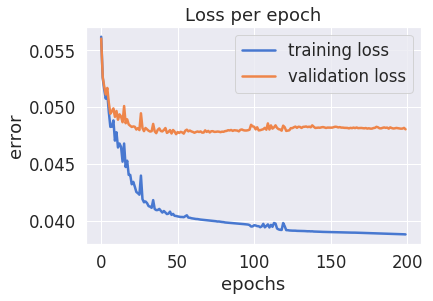

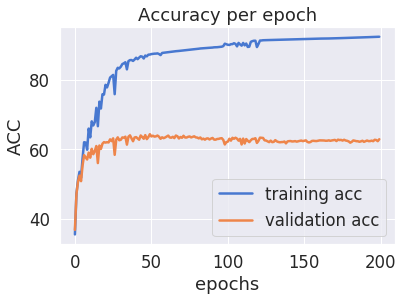

In [11]:
log = np.load('epochs/VGG16_normalized.npy')
visualize_results(log)

# CASE 2: Prune Pretrained VGG16

### Model

In [12]:
class VGG_drop1(nn.Module):
    def __init__(self, input_channel=1, num_class=7, pretrained=True):
        super(VGG_drop1, self).__init__()
        self.extra_channel = nn.Conv2d(1, 3, kernel_size=(1, 1))
        model_ft = models.vgg16(pretrained=pretrained)
        set_parameter_requires_grad(model_ft, False) 
        #change FC
        self.model_ft = nn.Sequential(*(list(model_ft.features.children())[:-7]))
        self.final_FC = nn.Linear(4608, 1024)
        self.class_fc = nn.Linear(1024, num_class)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.extra_channel(x)
        x = F.relu(x, inplace=True)
        
        #pruned VGG 
        x = self.model_ft(x)
        
        #final FC
        x = torch.flatten(x, 1)
        x = self.final_FC(x)
        x = F.relu(x, inplace=True)
        
        #classifier
        x_class = self.class_fc(x)
        
        return F.softmax(x_class, dim=1)

### Training

In [13]:
_model = VGG_drop1(num_class=7)
_model.to(device)
summary(_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 48, 48]           1,792
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]         147,584
             ReLU-10          [-1, 128, 24, 24]               0
        MaxPool2d-11          [-1, 128, 12, 12]               0
           Conv2d-12          [-1, 256, 12, 12]         295,168
             ReLU-13          [-1, 256, 12, 12]               0
           Conv2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.SGD(_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

log = training(Train_dataloader, model = _model, check_point = "VGG16_drop1")

### Results

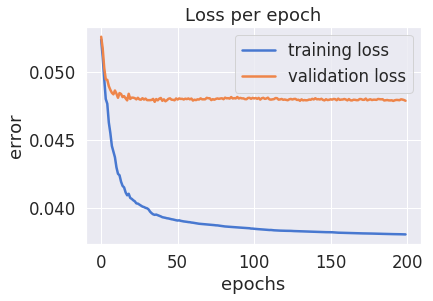

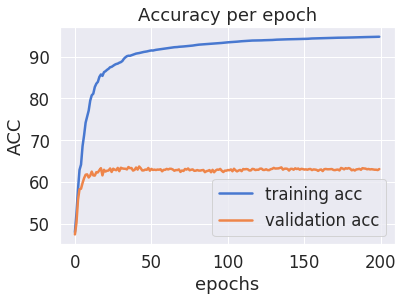

In [14]:
log = np.load('epochs/VGG16_drop1.npy')
visualize_results(log)

# CASE 3: Prune VGG16

In [15]:
_model = VGG_drop1(num_class=7, pretrained=False)
_model.to(device)
summary(_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 48, 48]           1,792
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]         147,584
             ReLU-10          [-1, 128, 24, 24]               0
        MaxPool2d-11          [-1, 128, 12, 12]               0
           Conv2d-12          [-1, 256, 12, 12]         295,168
             ReLU-13          [-1, 256, 12, 12]               0
           Conv2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.SGD(_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

log = training(Train_dataloader, model = _model, check_point = "VGG16_no_pretrained_drop1")

### Results

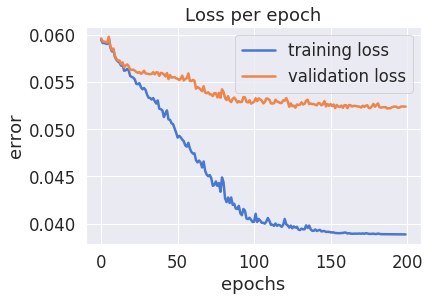

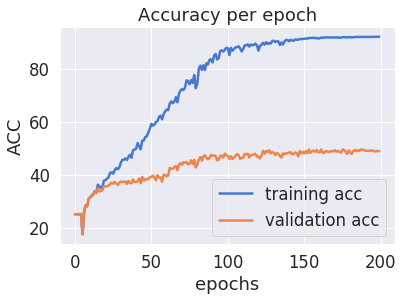

In [16]:
log = np.load('epochs/VGG16_no_pretrained_drop1.npy')
visualize_results(log)

# CASE 4: Pretrained ResNet18

In [17]:
class ResNet18(nn.Module):
    def __init__(self, input_channel=1, num_class=7, pretrained=True):
        super(ResNet18, self).__init__()
        self.extra_channel = nn.Conv2d(1, 3, kernel_size=(1, 1))
        model_ft = models.resnet18(pretrained=pretrained)
        set_parameter_requires_grad(model_ft, False) 
        #change FC
        self.model_ft = torch.nn.Sequential(*(list(model_ft.children())[:-1]))
        self.class_fc = nn.Linear(512, num_class)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.extra_channel(x)
        x = F.relu(x, inplace=True)
        
        #pruned VGG 
        x = self.model_ft(x)
        
        #final FC
        x = torch.flatten(x, 1)        
        #classifier
        x_class = self.class_fc(x)
        
        return F.softmax(x_class, dim=1)

In [18]:
_model = ResNet18(num_class=7)

_model.to(device)
summary(_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 24, 24]           9,408
       BatchNorm2d-3           [-1, 64, 24, 24]             128
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 64, 12, 12]          36,864
       BatchNorm2d-7           [-1, 64, 12, 12]             128
              ReLU-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          36,864
      BatchNorm2d-10           [-1, 64, 12, 12]             128
             ReLU-11           [-1, 64, 12, 12]               0
       BasicBlock-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 64, 12, 12]          36,864
      BatchNorm2d-14           [-1, 64,

### Results

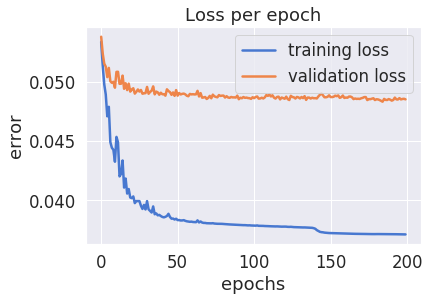

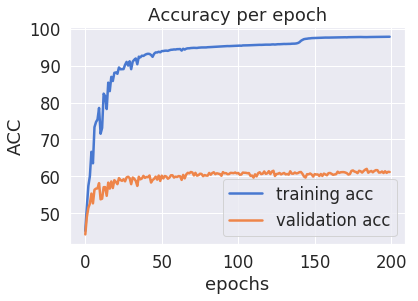

In [19]:
log = np.load('epochs/ResNet18_Pretrained.npy')
visualize_results(log)

# CASE 5: Prune Pretrained ResNet18

### Model

In [20]:
class ResNet18_drop2(nn.Module):
    def __init__(self, input_channel=1, num_class=7, pretrained=True):
        super(ResNet18_drop2, self).__init__()
        self.extra_channel = nn.Conv2d(1, 3, kernel_size=(1, 1))
        model_ft = models.resnet18(pretrained=pretrained)
        set_parameter_requires_grad(model_ft, False) 
        #change FC
        self.model_ft = torch.nn.Sequential(*(list(model_ft.children())[:-3]))
        self.class_fc = nn.Linear(2304, num_class)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.extra_channel(x)
        x = F.relu(x, inplace=True)
        
        #pruned VGG 
        x = self.model_ft(x)
        
        #final FC
        x = torch.flatten(x, 1)        
        #classifier
        x_class = self.class_fc(x)
        
        return F.softmax(x_class, dim=1)

### Training

In [21]:
_model = ResNet18_drop2(num_class=7)

_model.to(device)
summary(_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 24, 24]           9,408
       BatchNorm2d-3           [-1, 64, 24, 24]             128
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 64, 12, 12]          36,864
       BatchNorm2d-7           [-1, 64, 12, 12]             128
              ReLU-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          36,864
      BatchNorm2d-10           [-1, 64, 12, 12]             128
             ReLU-11           [-1, 64, 12, 12]               0
       BasicBlock-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 64, 12, 12]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
optimizer = torch.optim.SGD(_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

log = training(Train_dataloader, model = _model, check_point = "ResNet18_Pretrained_drop2")

### Results

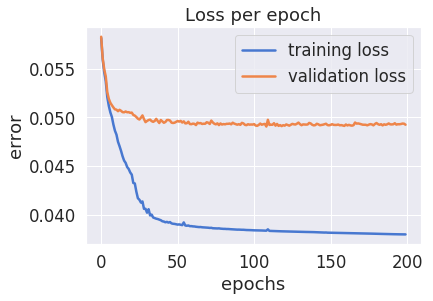

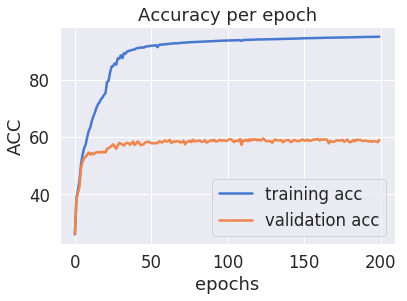

In [22]:
log = np.load('epochs/ResNet18_Pretrained_drop2.npy')
visualize_results(log)

# Case 6: VGG16 + Drop out

### Model

In [23]:
class VGG16_dropout(nn.Module):
    def __init__(self, input_channel=1, num_class=7):
        super(VGG16_dropout, self).__init__()
        self.extra_channel = nn.Conv2d(1, 3, kernel_size=(1, 1))
        model_ft = models.vgg16(pretrained=True)
        set_parameter_requires_grad(model_ft, False) 
        #change FC
        self.model_ft = nn.Sequential(*(list(model_ft.features.children())[:]))
        self.final_FC = nn.Linear(512, 1024)
        self.dropout = nn.Dropout(0.5)
        self.class_fc = nn.Linear(1024, num_class)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.extra_channel(x)
        x = F.relu(x, inplace=True)
        
        #pruned VGG 
        x = self.model_ft(x)
        
        #final FC
        x = torch.flatten(x, 1)
        x = self.final_FC(x)
        x = F.relu(x, inplace=True)
       
        #classifier
        x = self.dropout(x)
        x_class = self.class_fc(x)
        
        return F.softmax(x_class, dim=1)

### training

In [24]:
_model = VGG16_dropout(num_class=7)

_model.to(device)
summary(_model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 48, 48]           1,792
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]         147,584
             ReLU-10          [-1, 128, 24, 24]               0
        MaxPool2d-11          [-1, 128, 12, 12]               0
           Conv2d-12          [-1, 256, 12, 12]         295,168
             ReLU-13          [-1, 256, 12, 12]               0
           Conv2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.SGD(_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

log = training(Train_dataloader, model = _model, check_point = "VGG16_dropout")

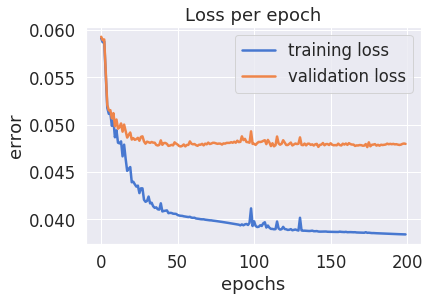

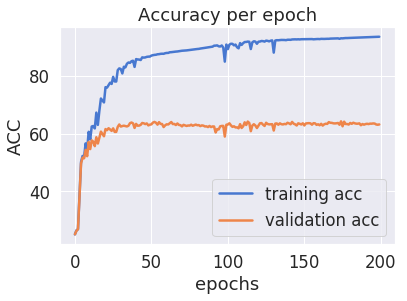

In [25]:
log = np.load('epochs/VGG16_dropout.npy')
visualize_results(log)

# Test Case

The adopted weights is which ones gain the highest accuracy on validation set

In [26]:
Test_data = FER(data_path + "fer2013_test.h5")
Test_dataloader = DataLoader(dataset=Test_data, batch_size = 32, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
print("VGG16")
_model = VGG16(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_normalized.pt'), strict=False)
acc_test, loss_test = validate(Test_dataloader, _model)
print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_test, acc_test))

print("VGG16 drop1")
_model = VGG_drop1(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_drop1.pt'), strict=False)
acc_test, loss_test = validate(Test_dataloader, _model)
print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_test, acc_test))

print("VGG16 dropout")
_model = VGG16_dropout(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_dropout.pt'), strict=False)
acc_test, loss_test = validate(Test_dataloader, _model)
print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_test, acc_test))

print("VGG16 drop1 no pretrained")
_model = VGG_drop1(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_no_pretrained_drop1.pt'), strict=False)
acc_test, loss_test = validate(Test_dataloader, _model)
print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_test, acc_test))

print("ResNet18")
_model = ResNet18(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/ResNet18_Pretrained.pt'), strict=False)
acc_test, loss_test = validate(Test_dataloader, _model)
print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_test, acc_test))

print("ResNet18 drop2")
_model = ResNet18_drop2(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/ResNet18_Pretrained_drop2.pt'), strict=False)
acc_test, loss_test = validate(Test_dataloader, _model)
print('Training Loss :{:.4f},  Accuracy of the model: {:.4f} %'.format(loss_test, acc_test))

|Model | Loss | Accuracy |
| --- | --- | --- |
| VGG16 | 0.0484 | 62.7194 % |
| --- | --- | --- |
| VGG16 drop1 | 0.0482 | 62.0228 % |
| --- | --- | --- |
| VGG16 dropout | 0.0481 | 63.3324 % |
| --- | --- | --- |
| VGG16 drop1 no pretrained | 0.0527 | 48.5651 % |
| --- | --- | --- |
| ResNet18 | 0.0491 | 60.0446 % |
| --- | --- | --- |
| ResNet18 drop2 | 0.0499 | 57.2583 % |

# Kernel visualization

In [27]:
def plot_filters_single_channel(t, ncols = 10):
    
    nplots = t.shape[0]*t.shape[1]
    nrows = nplots // ncols + 1
    
    npimg = np.array(t.numpy(), np.float32)
    count = 0
    fig = plt.figure(figsize=(ncols, nrows), dpi=100)
    
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / (np.std(npimg) + 10e-6)
            #remove 1 < and 0 >
            npimg = np.clip(npimg, 0, 1)
            ax1.imshow(npimg, cmap="viridis")
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    
    plt.tight_layout()
    plt.show()
    
def plot_weights(model, layer_num, single_channel = True, ncols = 10):
  
    layer = model.model_ft[layer_num]
  
    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = layer.weight.data
        weight_tensor = weight_tensor.cpu()
        print(weight_tensor.size())
        plot_filters_single_channel(weight_tensor, ncols)
                   
    else:
        print("Can only visualize layers which are convolutional")

torch.Size([64, 3, 3, 3])


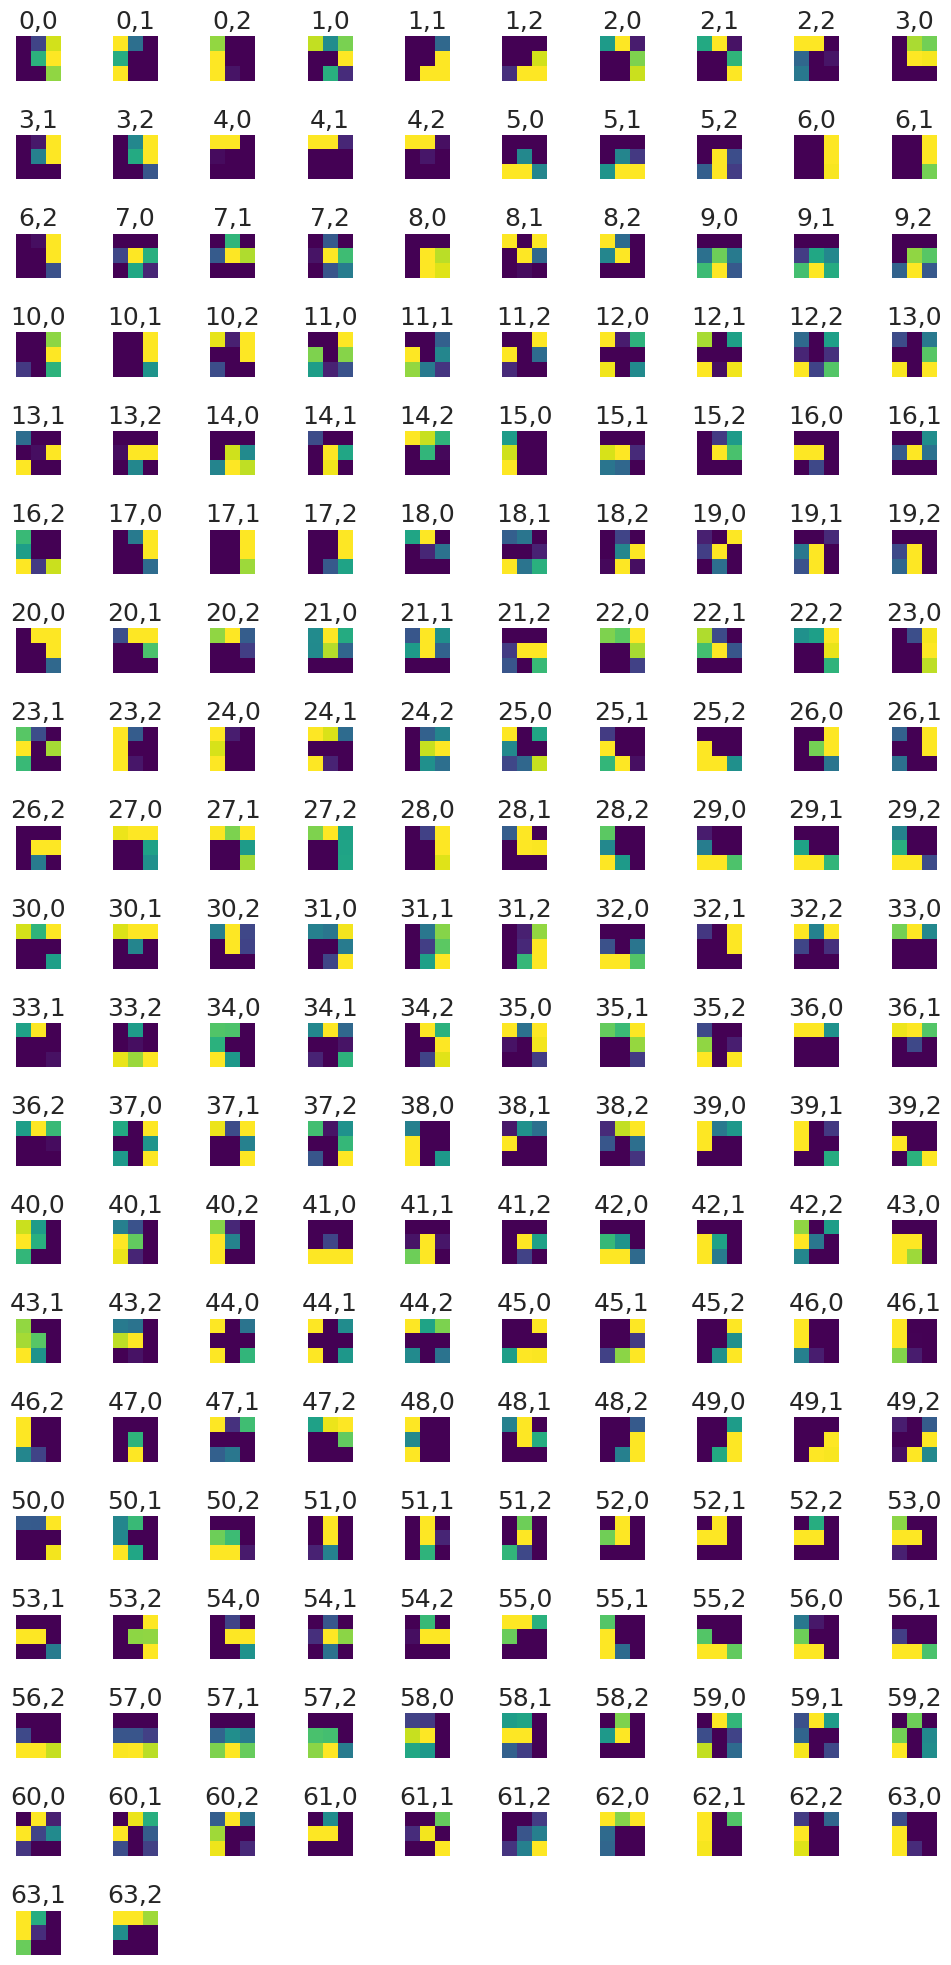

In [28]:
_model = VGG16(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_normalized.pt'), strict=False)
plot_weights(_model, 0, single_channel = True)

# Feature maps visualization

In [29]:
class SaveFeatures():
    """hook function at forward step"""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

def plot_featuremaps(pic, model, layer_num, ncols = 10):
  
    l = [module for module in model.modules() if (type(module) != nn.Sequential())]
    layer = l[layer_num]
    print(layer)
    activations = SaveFeatures(layer)
    
    tensor = pic.to(device).float()
    output = model(tensor)
    feature_maps = activations.features[0].detach().cpu()
    feature_maps = feature_maps[None, :]
    print(feature_maps.size())
    
    plot_filters_single_channel(feature_maps, ncols)

Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
torch.Size([1, 3, 48, 48])


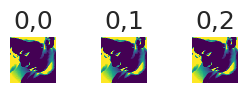

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 48, 48])


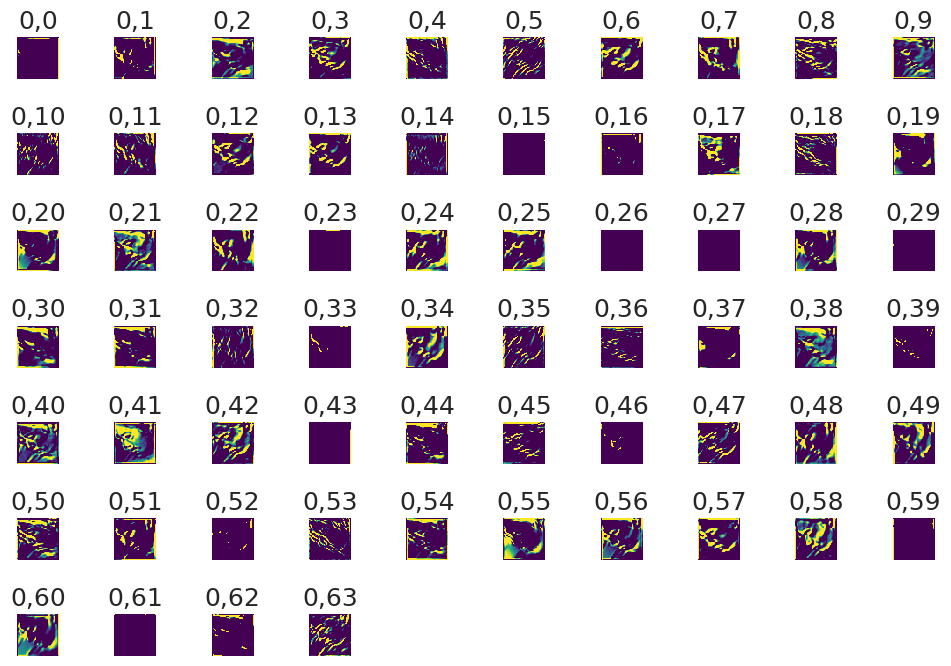

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 24, 24])


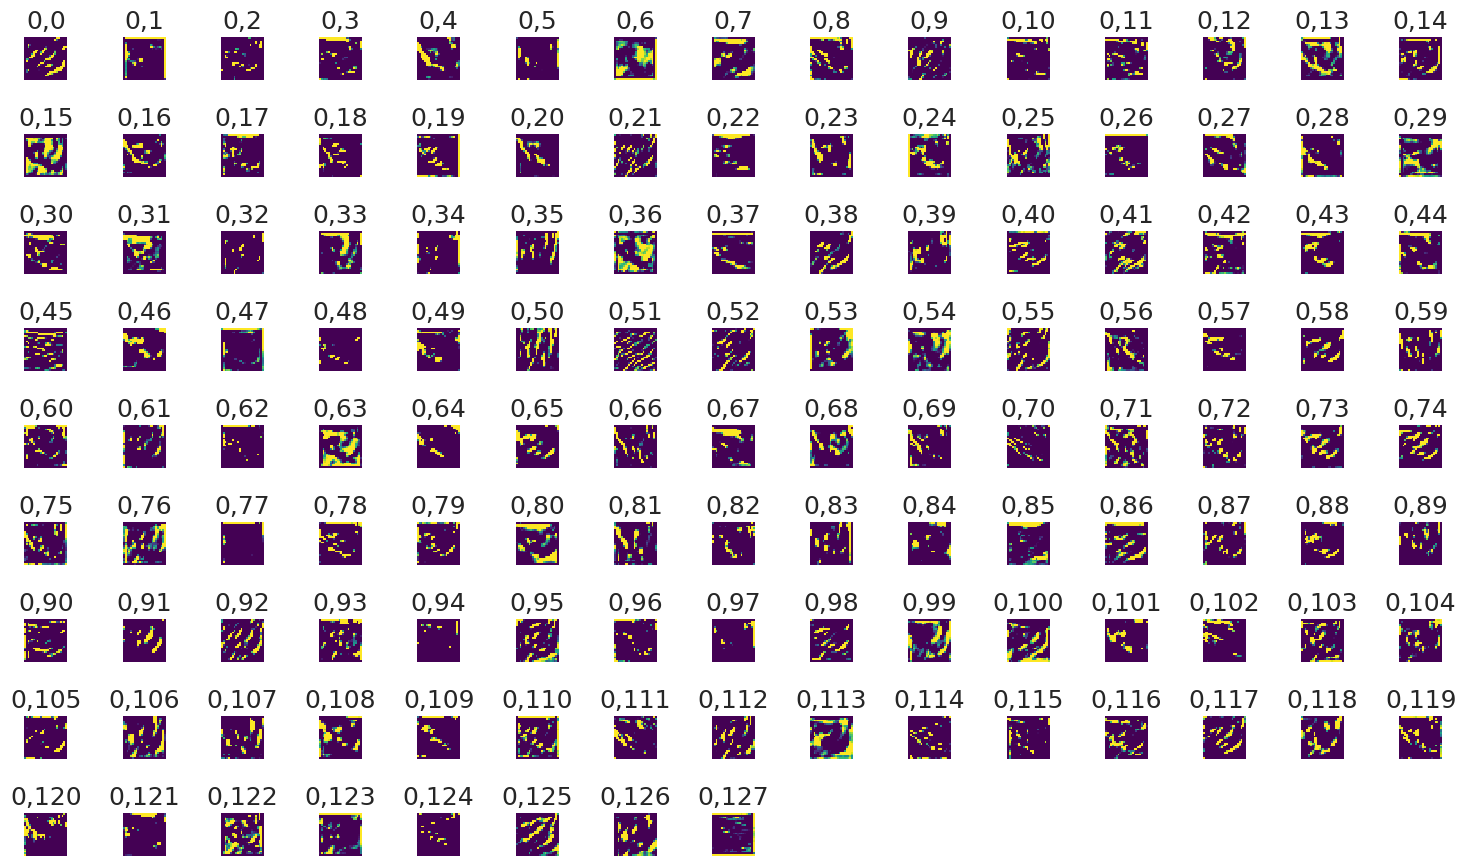

In [30]:
_model = VGG16(num_class=7)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_normalized.pt'), strict=False)

images, _ = next(iter(Train_dataloader))
plot_featuremaps(images, _model, 1, ncols = 3)
plot_featuremaps(images, _model, 5, ncols = 10)
plot_featuremaps(images, _model, 10, ncols = 15)